In [136]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math

#dummy variables = pandas one hot encoding
#dictonaries to pd dataframes
#relationship between x and y(revenue)
#pandas dict to df

In [137]:
test=pd.read_csv('input/test.csv')

In [138]:
train=pd.read_csv('input/train.csv')

In [139]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [140]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


Data Description id - Integer unique id of each movie

belongs_to_collection - Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format. 

budget:Budget of a movie in dollars. 0 values mean unknown.

genres : Contains all the Genres Name & TMDB Id in JSON Format

homepage - Contains the official homepage URL of a movie. 

imdb_id - IMDB id of a movie (string). 

original_language - Two digit code of the original language, in which the movie was made. Like: en = English, fr = french.

original_title - The original title of a movie. Title & Original title may differ, if the original title is not in English.

overview - Brief description of the movie.

popularity - Popularity of the movie in float.

poster_path - Poster path of a movie. 

production_companies - All production company name and TMDB id in JSON format of a movie.

production_countries - Two digit code and full name of the production company in JSON format.

release_date - Release date of a movie in mm/dd/yy format.

runtime - Total runtime of a movie in minutes (Integer).

spoken_languages - Two digit code and full name of the spoken language.

status - Is the movie released or rumored?

tagline - Tagline of a movie

title - English title of a movie

Keywords - TMDB Id and name of all the keywords in JSON format.

cast - All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format

crew - Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc.

revenue - Total revenue earned by a movie in dollars.

In [141]:
test.shape

(4398, 22)

In [142]:
train.shape

(3000, 23)

In [143]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [145]:
train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,...,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,...,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt1529572,en,The Women,"Jack Chester, an overworked air traffic contro...",NaN,...,9/10/15,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Hot Pursuit,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '52fe495ac3a36847f8195d4d', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,...,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,...,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,...,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,...,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,...,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,...,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


In [146]:
train.isna().sum().sort_values(ascending=False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64

In [147]:
#belongs_to_collection

for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 nan
3 nan
4 nan


In [148]:
import ast
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

#access the dictionaries
def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
dfx = text_to_dict(train)
for col in dict_columns:
       train[col]=dfx[col]
        
dfy = text_to_dict(test)
for col in dict_columns:
       test[col]=dfy[col]

In [149]:
train['belongs_to_collection'].apply(lambda x:len(x) if x!= {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [150]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)

In [151]:
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

In [152]:
test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)

In [153]:
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

In [154]:
train.head()

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,0
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0,0


In [155]:
#genres

for i, e in enumerate(train['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [156]:
print('Number of genres in films')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

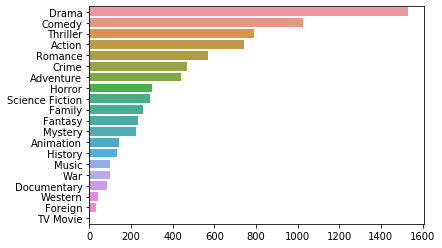

In [157]:
genre=train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(20)
sns.barplot([val[1] for val in count],[val[0] for val in count])

In [158]:
# create columns all genres and number of genres
train['all_genres'] = train['genres'].apply(lambda x: sorted([i['name'] for i in x]) if x != {} else '')
train['num_genres']=train['genres'].apply(lambda x: len(x) if x != {} else 0)
#create dummy variables
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
all_genress = list(Counter([i for j in list_of_genres for i in j]))
others_genres=list(set(all_genress)-set(top_genres))
for g in top_genres:
    train[g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)

for g in others_genres:
    train['genres_others'] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
#for row in train:
#    if sum(row[25:])<row['num_genres']:
#        row['genres_others']=1
#    else: row['genres_others']=0
        
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test[g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)
for g in others_genres:
    test['genres_others'] = test['all_genres'].apply(lambda x: 1 if g in x else 0)
train = train.drop(['genres','all_genres'], axis=1)
test = test.drop(['genres','all_genres'], axis=1)

In [159]:
print(others_genres)

['War', 'TV Movie', 'Foreign', 'Western', 'Documentary']


In [160]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 40 columns):
id                      3000 non-null int64
budget                  3000 non-null int64
homepage                946 non-null object
imdb_id                 3000 non-null object
original_language       3000 non-null object
original_title          3000 non-null object
overview                2992 non-null object
popularity              3000 non-null float64
poster_path             2999 non-null object
production_companies    3000 non-null object
production_countries    3000 non-null object
release_date            3000 non-null object
runtime                 2998 non-null float64
spoken_languages        3000 non-null object
status                  3000 non-null object
tagline                 2403 non-null object
title                   3000 non-null object
Keywords                3000 non-null object
cast                    3000 non-null object
crew                    3000 non-null o

In [161]:
#production companies
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [162]:
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

In [163]:
train['all_pd_com'] = train['production_companies'].apply(lambda x: sorted([i['name'] for i in x]) if x != {} else '')
train['num_pd_com']=train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
#create dummy variables
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
all_pd_coms = list(Counter([i for j in list_of_companies for i in j]))
others_pd_com=list(set(all_pd_coms)-set(top_companies))

for g in top_companies:
    train['pd_com_' + g] = train['all_pd_com'].apply(lambda x: 1 if g in x else 0)
for g in others_pd_com:
    train['pd_com_others'] = train['all_pd_com'].apply(lambda x: 1 if g in x else 0)
    

test['all_pd_com'] = test['production_companies'].apply(lambda x: sorted([i['name'] for i in x]) if x != {} else '')
test['num_pd_com']=test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
#create dummy variables

for g in top_companies:
    test['pd_com_' + g] = test['all_pd_com'].apply(lambda x: 1 if g in x else 0)
for g in others_pd_com:
    test['pd_com_others'] = test['all_pd_com'].apply(lambda x: 1 if g in x else 0)
        
#train['all_pd_com'].str.join(sep='*').str.get_dummies(sep='*')
#train = pd.concat([train.drop('production_companies', axis=1), train['all_pd_com'].str.join(sep='*').str.get_dummies(sep='*')], axis=1)
#train.info()
train = train.drop(['production_companies', 'all_pd_com'], axis=1)
test = test.drop(['production_companies', 'all_pd_com'], axis=1)

In [164]:
# production countries 
for i, e in enumerate(train['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [165]:
print('Number of production countries in films')
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production countries in films


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

In [166]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10)]

In [167]:
train['num_pd_cnt'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_pd_cnt']=train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
#create dummy variables
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
all_pd_cnts = list(Counter([i for j in list_of_countries for i in j]))
others_pd_cnt=list(set(all_pd_cnts)-set(top_countries))
train['all_pd_cnt']
for g in top_countries:
    train['pd_cnt_' + g] = train['all_pd_cnt'].apply(lambda x: 1 if g in x else 0)    
for g in others_pd_cnt:
    train['pd_cnt_others'] = train['all_pd_cnt'].apply(lambda x: 1 if g in x else 0)
    
test['num_pd_cnt'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_pd_cnt'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['pd_cnt_' + g] = test['all_pd_cnt'].apply(lambda x: 1 if g in x else 0)
for g in others_pd_cnt:
    test['pd_cnt_others'] = test['all_pd_cnt'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_pd_cnt'], axis=1)
test = test.drop(['production_countries', 'all_pd_cnt'], axis=1)

#train['all_cnt_com'][1]
#train['all_pd_cnt'].str.join(sep='*').str.get_dummies(sep='*')
#train = pd.concat([train.drop('production_countries', axis=1), train['all_pd_cnt'].str.join(sep='*').str.get_dummies(sep='*')], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 97 columns):
id                                               3000 non-null int64
budget                                           3000 non-null int64
homepage                                         946 non-null object
imdb_id                                          3000 non-null object
original_language                                3000 non-null object
original_title                                   3000 non-null object
overview                                         2992 non-null object
popularity                                       3000 non-null float64
poster_path                                      2999 non-null object
release_date                                     3000 non-null object
runtime                                          2998 non-null float64
spoken_languages                                 3000 non-null object
status                                           3000 

In [168]:
# spoken languages
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [169]:
print('Number of spoken languages in films')
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [170]:
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [171]:
train['num_lg'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_lg'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
#create dummy variables
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
all_lgs = list(Counter([i for j in list_of_languages for i in j]))
others_lg=list(set(all_lgs)-set(top_languages))
for g in top_languages:
    train['lg_' + g] = train['all_lg'].apply(lambda x: 1 if g in x else 0)
for g in others_lg:
    train['lg_others'] = train['all_lg'].apply(lambda x: 1 if g in x else 0)

    
test['num_lg'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_lg'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test['lg_' + g] = test['all_lg'].apply(lambda x: 1 if g in x else 0)
for g in others_lg:
    test['lg_others'] = test['all_lg'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop(['spoken_languages', 'all_lg'], axis=1)
test = test.drop(['spoken_languages', 'all_lg'], axis=1)
#train['all_cnt_com'][1]
# train['all_lng'].str.join(sep='*').str.get_dummies(sep='*')
#train = pd.concat([train.drop('production_countries', axis=1), train['all_pd_cnt'].str.join(sep='*').str.get_dummies(sep='*')], axis=1)
#train.head()

In [172]:
#Keywords
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [173]:
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

In [174]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_key'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_key'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
#create dummy variables
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
all_keys = list(Counter([i for j in list_of_keywords for i in j]))
others_key=list(set(all_keys)-set(top_keywords))
for g in top_keywords:
    train['key_' + g] = train['all_key'].apply(lambda x: 1 if g in x else 0)
for g in others_key:
    train['key_others'] = train['all_key'].apply(lambda x: 1 if g in x else 0)
    
test['num_key'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_key'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['key_' + g] = test['all_key'].apply(lambda x: 1 if g in x else 0)
for g in others_key:
    test['key_others'] = test['all_key'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop(['Keywords', 'all_key'], axis=1)
test = test.drop(['Keywords', 'all_key'], axis=1)
#train['all_cnt_com'][1]
# train['all_key'].str.join(sep='*').str.get_dummies(sep='*')
#train = pd.concat([train.drop('production_countries', axis=1), train['all_pd_cnt'].str.join(sep='*').str.get_dummies(sep='*')], axis=1)
#train.head()

In [175]:
# cast
for i, e in enumerate(train['cast'][:1]):
    print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [176]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

In [177]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

In [178]:
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()
#0 is unspecified, 1 is female, 2 is male

[(2, 27949), (0, 20329), (1, 13533)]

In [179]:
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

In [180]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
# all_cast_names = list(Counter([i for j in list_of_cast_names for i in j]))
# others_cast_names=list(set(all_cast_names)-set(top_cast_names))
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
# for g in others_cast_names:
#     train['cast_name_others'] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
# all_cast_chr = list(Counter([i for j in list_of_cast_characters for i in j]))
# others_cast_chr=list(set(all_cast_chr)-set(top_cast_characters))
for g in top_cast_characters:
    train['cast_chr_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
# for g in others_cast_chr:
#     train['cast_chr_others'] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test['cast_name_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
# for g in others_cast_names:
#     test['cast_name_others'] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

for g in top_cast_characters:
    test['cast_chr_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
# for g in others_cast_chr:
#     test['cast_chr_others'] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

In [181]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,cast_chr_Doctor,cast_chr_Reporter,cast_chr_Waitress,cast_chr_Nurse,cast_chr_Bartender,cast_chr_Jack,cast_chr_Debutante,cast_chr_Security Guard,cast_chr_Paul,cast_chr_Frank
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2/20/15,...,0,0,0,0,0,0,0,0,0,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,8/6/04,...,0,0,0,0,0,0,0,0,1,0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,10/10/14,...,0,0,0,0,1,0,0,0,1,1
3,4,1200000,http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,3/9/12,...,0,0,0,0,0,0,0,0,0,0
4,5,0,NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,2/5/09,...,0,0,0,0,0,0,0,0,0,0


In [182]:
# crew
for i, e in enumerate(train['crew'][:1]):
    print(i, e[:10])

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [183]:
print('Number of casted persons in films')
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


2     179
11    127
10    126
3     126
12    110
9     109
8     109
14    104
4     101
7      94
Name: crew, dtype: int64

In [184]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [185]:
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

In [186]:
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 41787), (2, 24898), (1, 6412)]

In [187]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303),
 ('Actors', 4)]

In [188]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
# all_crew_names = list(Counter([i for j in list_of_crew_names for i in j]))
# others_crew_names=list(set(all_crew_names)-set(top_crew_names))
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
# for g in others_crew_names:
#     train['crew_name_others'] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)    
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
# all_crew_jobs = list(Counter([i for j in list_of_crew_jobs for i in j]))
# others_crew_jobs=list(set(all_crew_jobs)-set(top_crew_jobs))
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
# for j in others_crew_jobs:
#     train['jobs_others'] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j])) 
    
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
# all_crew_deps = list(Counter([i for j in list_of_crew_departments for i in j]))
# others_crew_deps=list(set(all_crew_deps)-set(top_crew_departments))
for j in top_crew_departments:
    train['deps_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
# for j in others_crew_deps:
#     train['deps_others'] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j]))
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
# for g in others_crew_names:
#     test['crew_name_others'] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)    
    
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
# for j in others_crew_jobs:
#     test['jobs_others'] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j])) 
    
for j in top_crew_departments:
    test['deps_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j]))
# for j in others_crew_deps:
#     test['deps_others'] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j]))

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

## Data Exploration

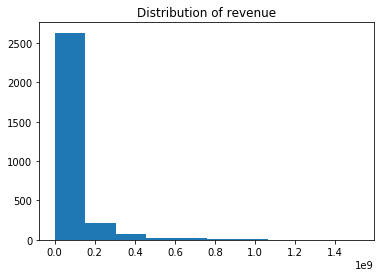

In [189]:
#Revenue
plt.hist(train['revenue'])
plt.title('Distribution of revenue')
plt.show()

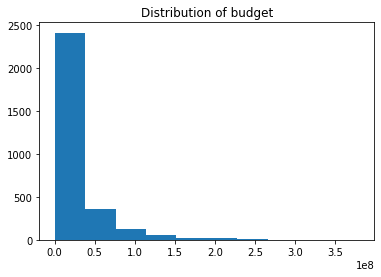

In [190]:
#Budget
plt.hist(train['budget'])
plt.title('Distribution of budget')
plt.show()

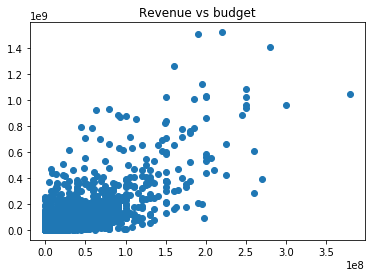

In [191]:
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget')
plt.show()

In [192]:
#Homepage
train['homepage'].describe()

count                                   946
unique                                  941
top       http://www.transformersmovie.com/
freq                                      4
Name: homepage, dtype: object

In [193]:
train['has_homepage'] = train['homepage'].apply(lambda x: 1 if not pd.isnull(x) else 0)

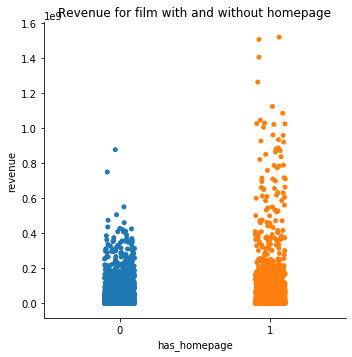

In [194]:
sns.catplot(x='has_homepage', y='revenue', data=train)
plt.title('Revenue for film with and without homepage')
plt.show()

In [195]:
#original_language
train['original_language'].describe()

count     3000
unique      36
top         en
freq      2575
Name: original_language, dtype: object

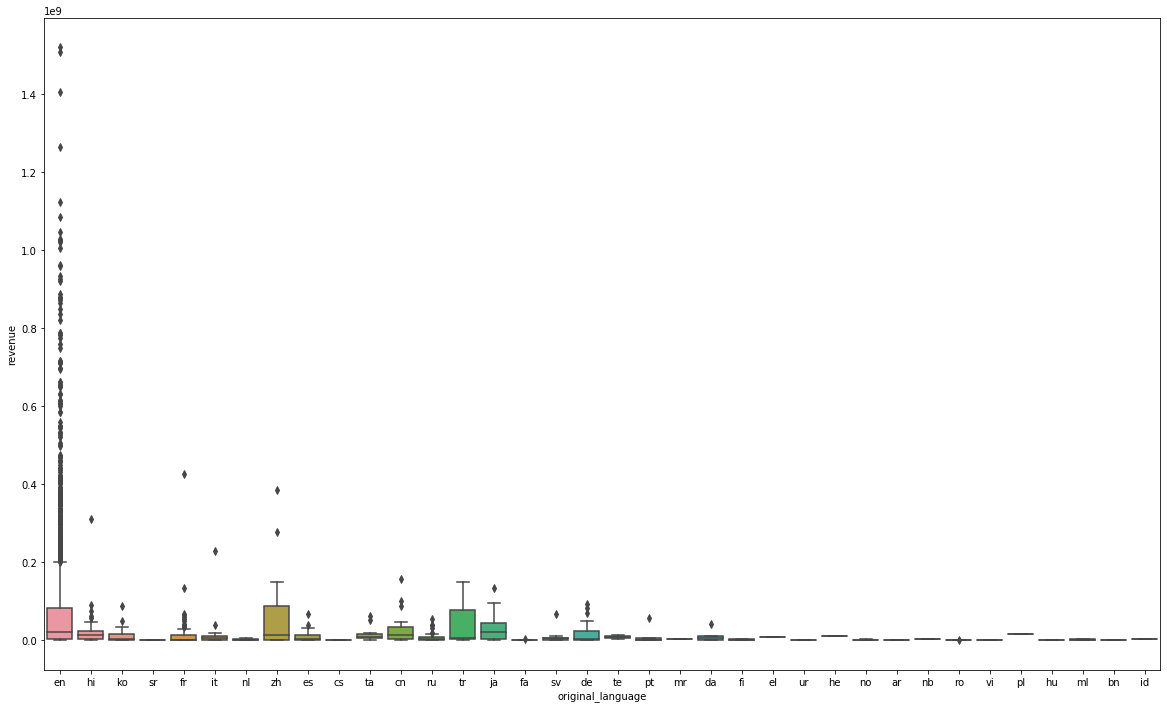

In [196]:
plt.figure(figsize=(20,12))
sns.boxplot(x='original_language', y='revenue', data=train)
plt.show()

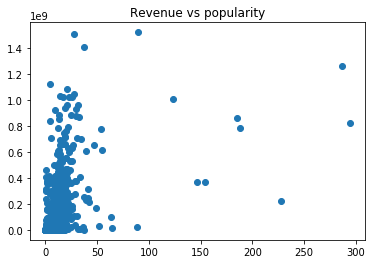

In [197]:
#popularity
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity')
plt.show()

In [198]:
#release_date
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

#Since only last two digits of year are provided
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
# Some rows have 4 digits of year instead of 2, that's why (train['release_year'] < 100) 
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek
train['release_quarter'] = releaseDate.dt.quarter

test[['release_month','release_day','release_year']]=test['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
test.loc[ (test['release_year'] <= 19) & (test['release_year'] < 100), "release_year"] += 2000
test.loc[ (test['release_year'] > 19)  & (test['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(test['release_date']) 
test['release_dayofweek'] = releaseDate.dt.dayofweek
test['release_quarter'] = releaseDate.dt.quarter

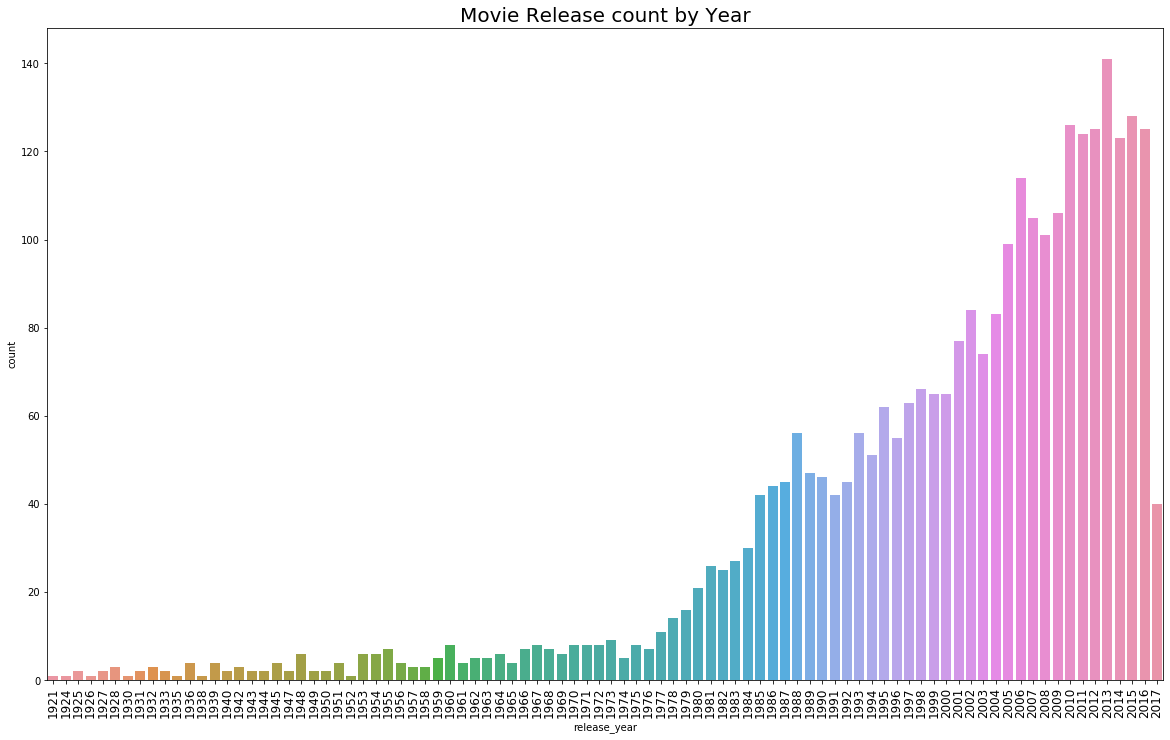

In [199]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_year'].sort_values())
plt.title("Movie Release count by Year",fontsize=20)
plt.xticks(fontsize=12,rotation=90)
plt.show()

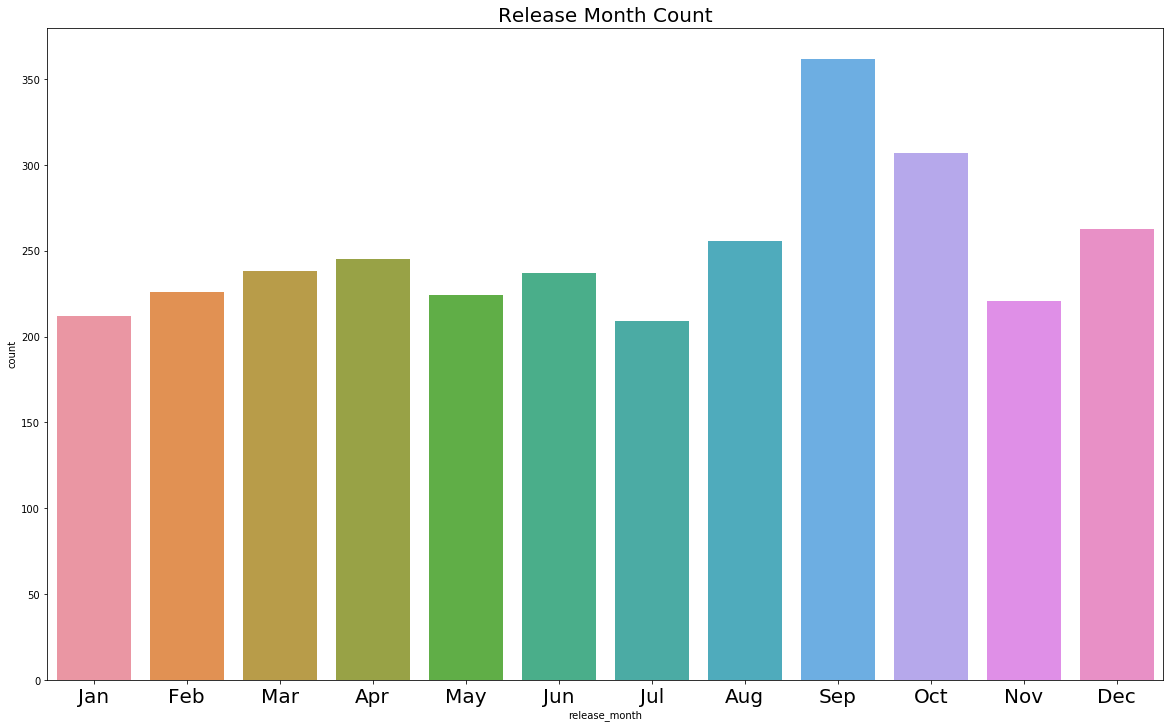

In [200]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_month'].sort_values())
plt.title("Release Month Count",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

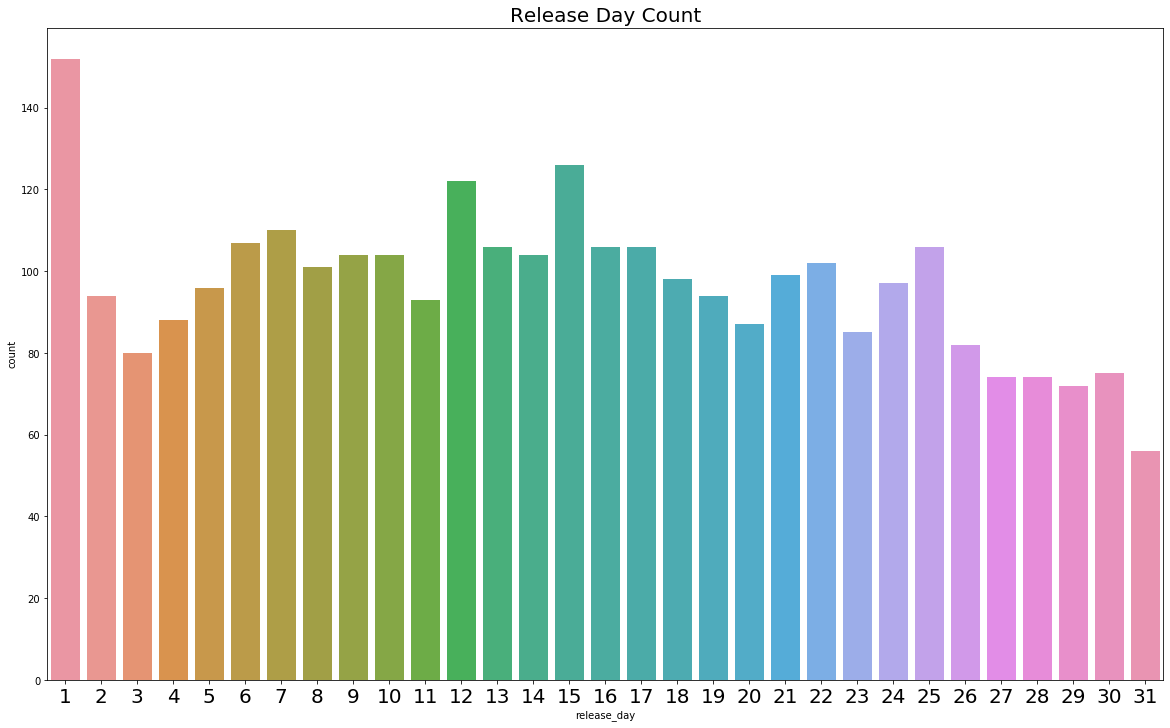

In [201]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_day'].sort_values())
plt.title("Release Day Count",fontsize=20)
plt.xticks(fontsize=20)
plt.show()

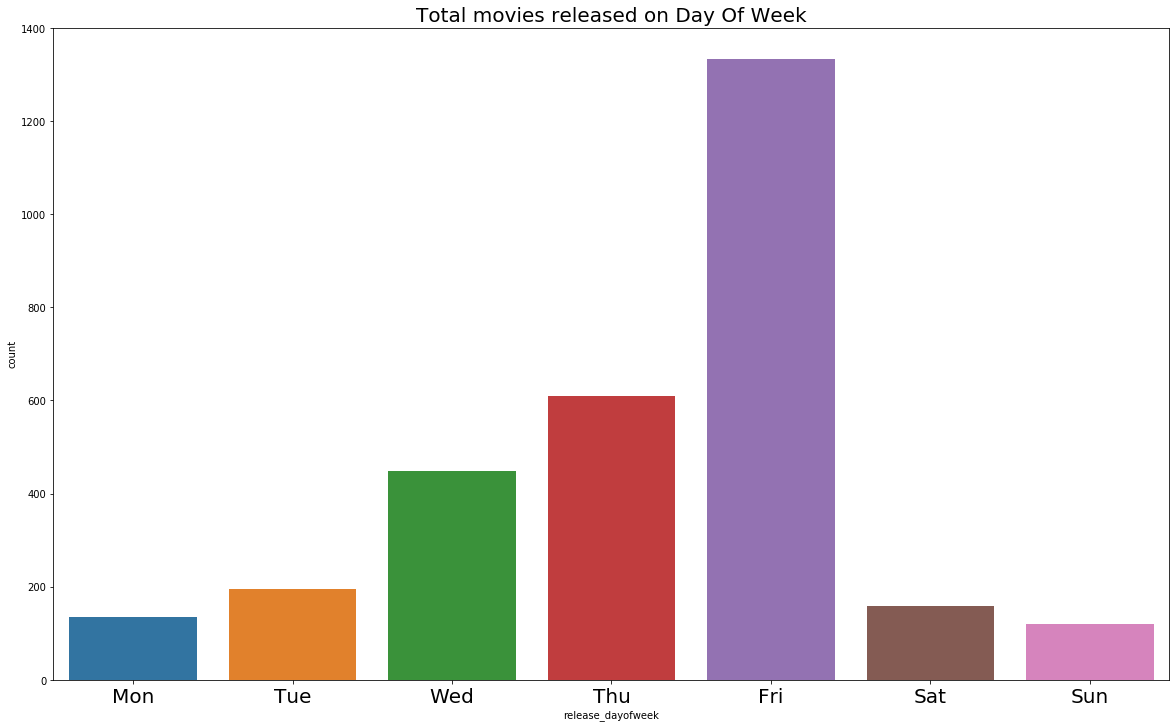

In [202]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_dayofweek'].sort_values())
plt.title("Total movies released on Day Of Week",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

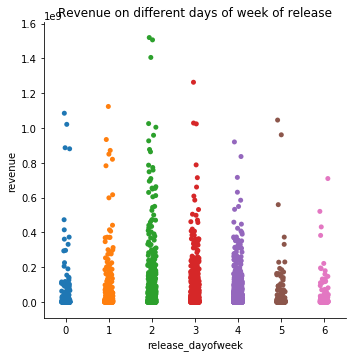

In [203]:
sns.catplot(x='release_dayofweek', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

Text(0.5, 1.0, 'Average revenue per year')

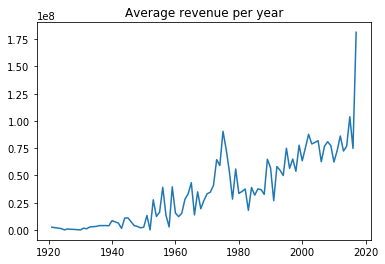

In [215]:
#d1 = train['release_year'].value_counts().sort_index()
d2 = train.groupby(['release_year'])['revenue'].mean()
#df=pd.DataFrame({'x1': d1, 'x2': d2})
#plt.plot(d1)
plt.plot(d2)
plt.title("Average revenue per year")
# plt.plot( 'x1', 'x2', data=df, marker='', color='olive', linewidth=2)

Text(0.5, 1.0, 'runtime vs popularity')

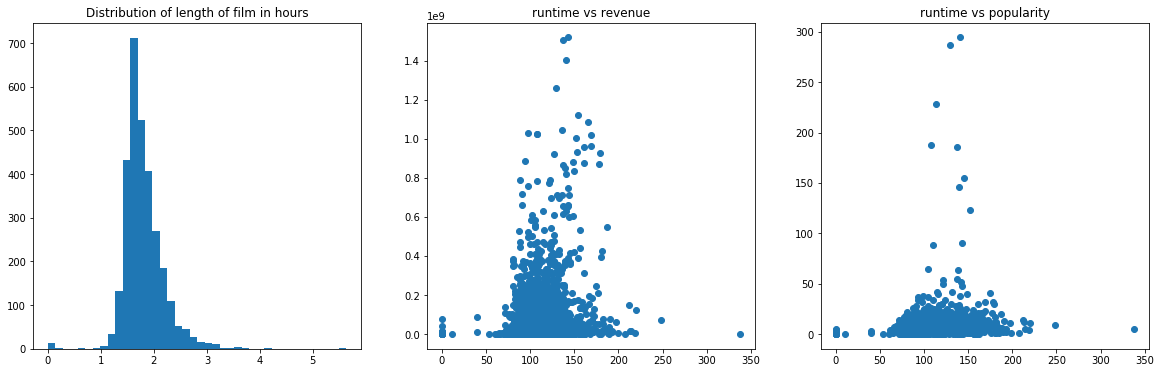

In [216]:
#runtime
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity')

In [217]:
#status
train['status'].describe()

count         3000
unique           2
top       Released
freq          2996
Name: status, dtype: object

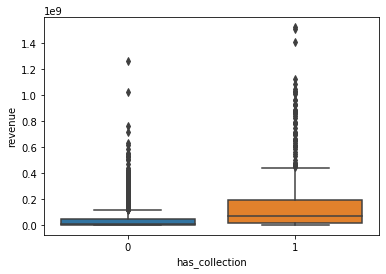

In [218]:
#collections
sns.boxplot(x='has_collection', y='revenue', data=train)
plt.show()

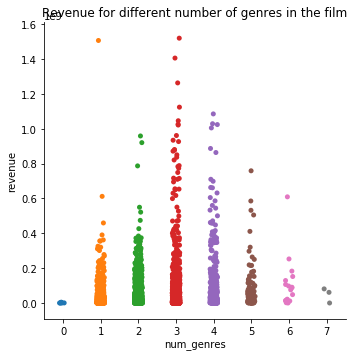

In [219]:
#genres
sns.catplot(x='num_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film')
plt.show()

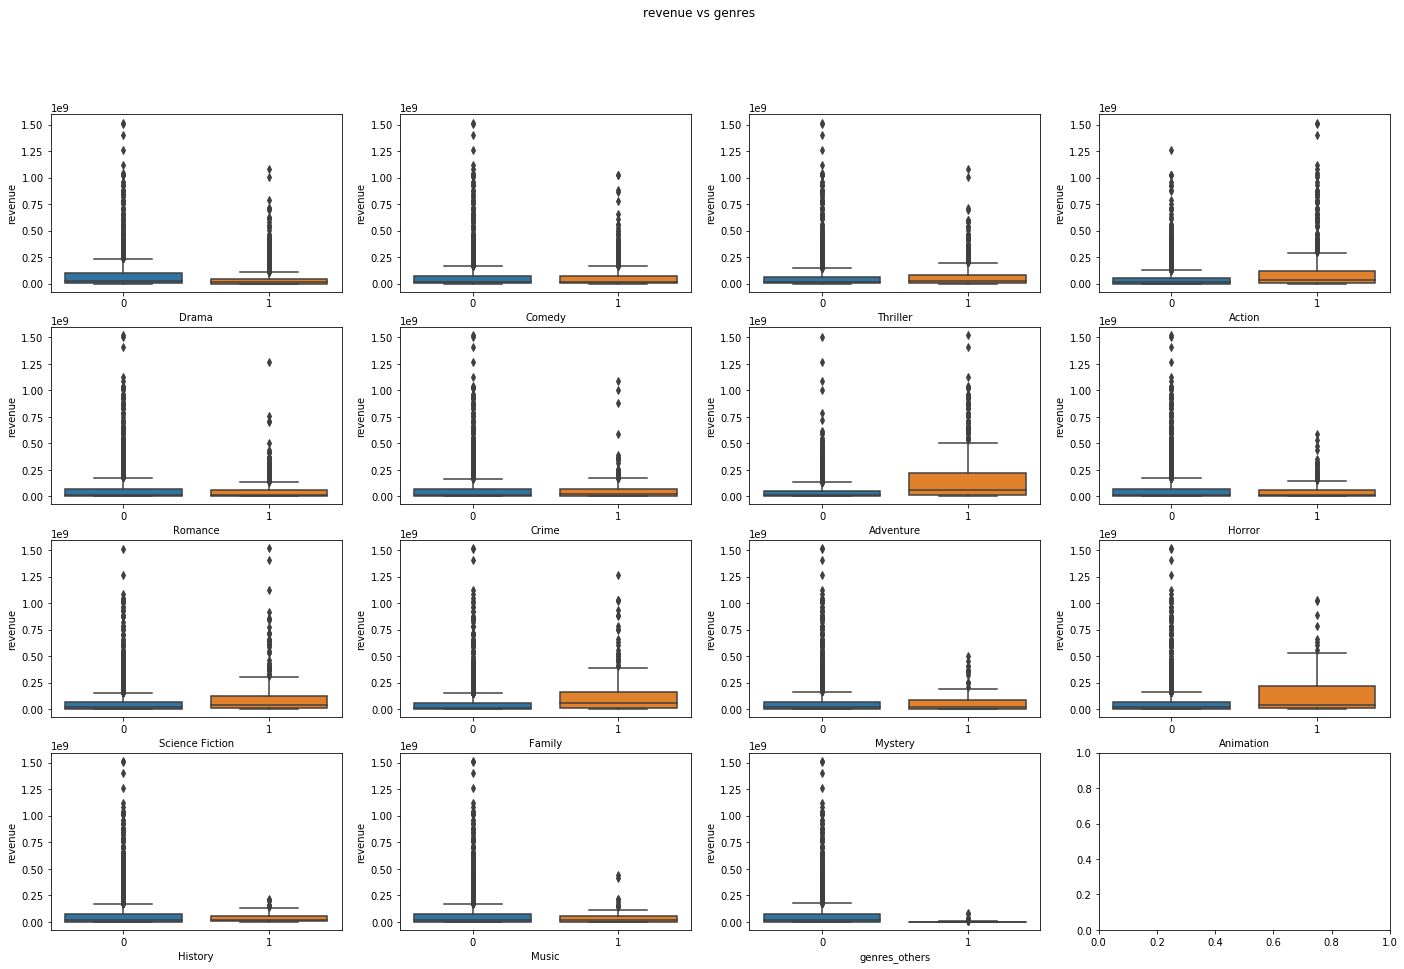

In [223]:
f, axes = plt.subplots(4, 4, figsize=(24, 15))
plt.suptitle('revenue vs genres')
for i, e in enumerate([col for col in ['Drama','Comedy','Thriller','Action','Romance','Crime','Adventure','Horror','Science Fiction','Family','Mystery','Animation','History', 'Music','genres_others']]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i // 4][i % 4]);

In [225]:
#train.to_excel('train2.xlsx')

In [226]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,deps_Editing,deps_Visual Effects,deps_Lighting,deps_Actors,has_homepage,release_month,release_day,release_year,release_dayofweek,release_quarter
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2/20/15,...,2,4,4,0,0,2,20,2015,4,1
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,8/6/04,...,1,0,0,0,0,8,6,2004,4,3
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,10/10/14,...,6,3,1,0,1,10,10,2014,4,4
3,4,1200000,http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,3/9/12,...,0,0,0,0,1,3,9,2012,4,1
4,5,0,NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,2/5/09,...,0,0,0,0,0,2,5,2009,3,1


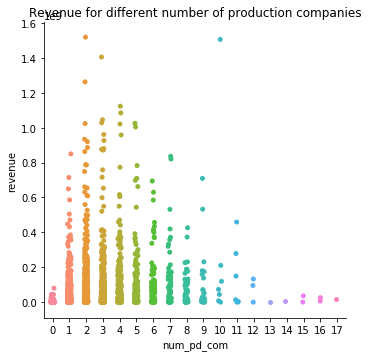

In [104]:
#production companies
sns.catplot(x='num_pd_com', y='revenue', data=train);
plt.title('Revenue for different number of production companies')
plt.show()

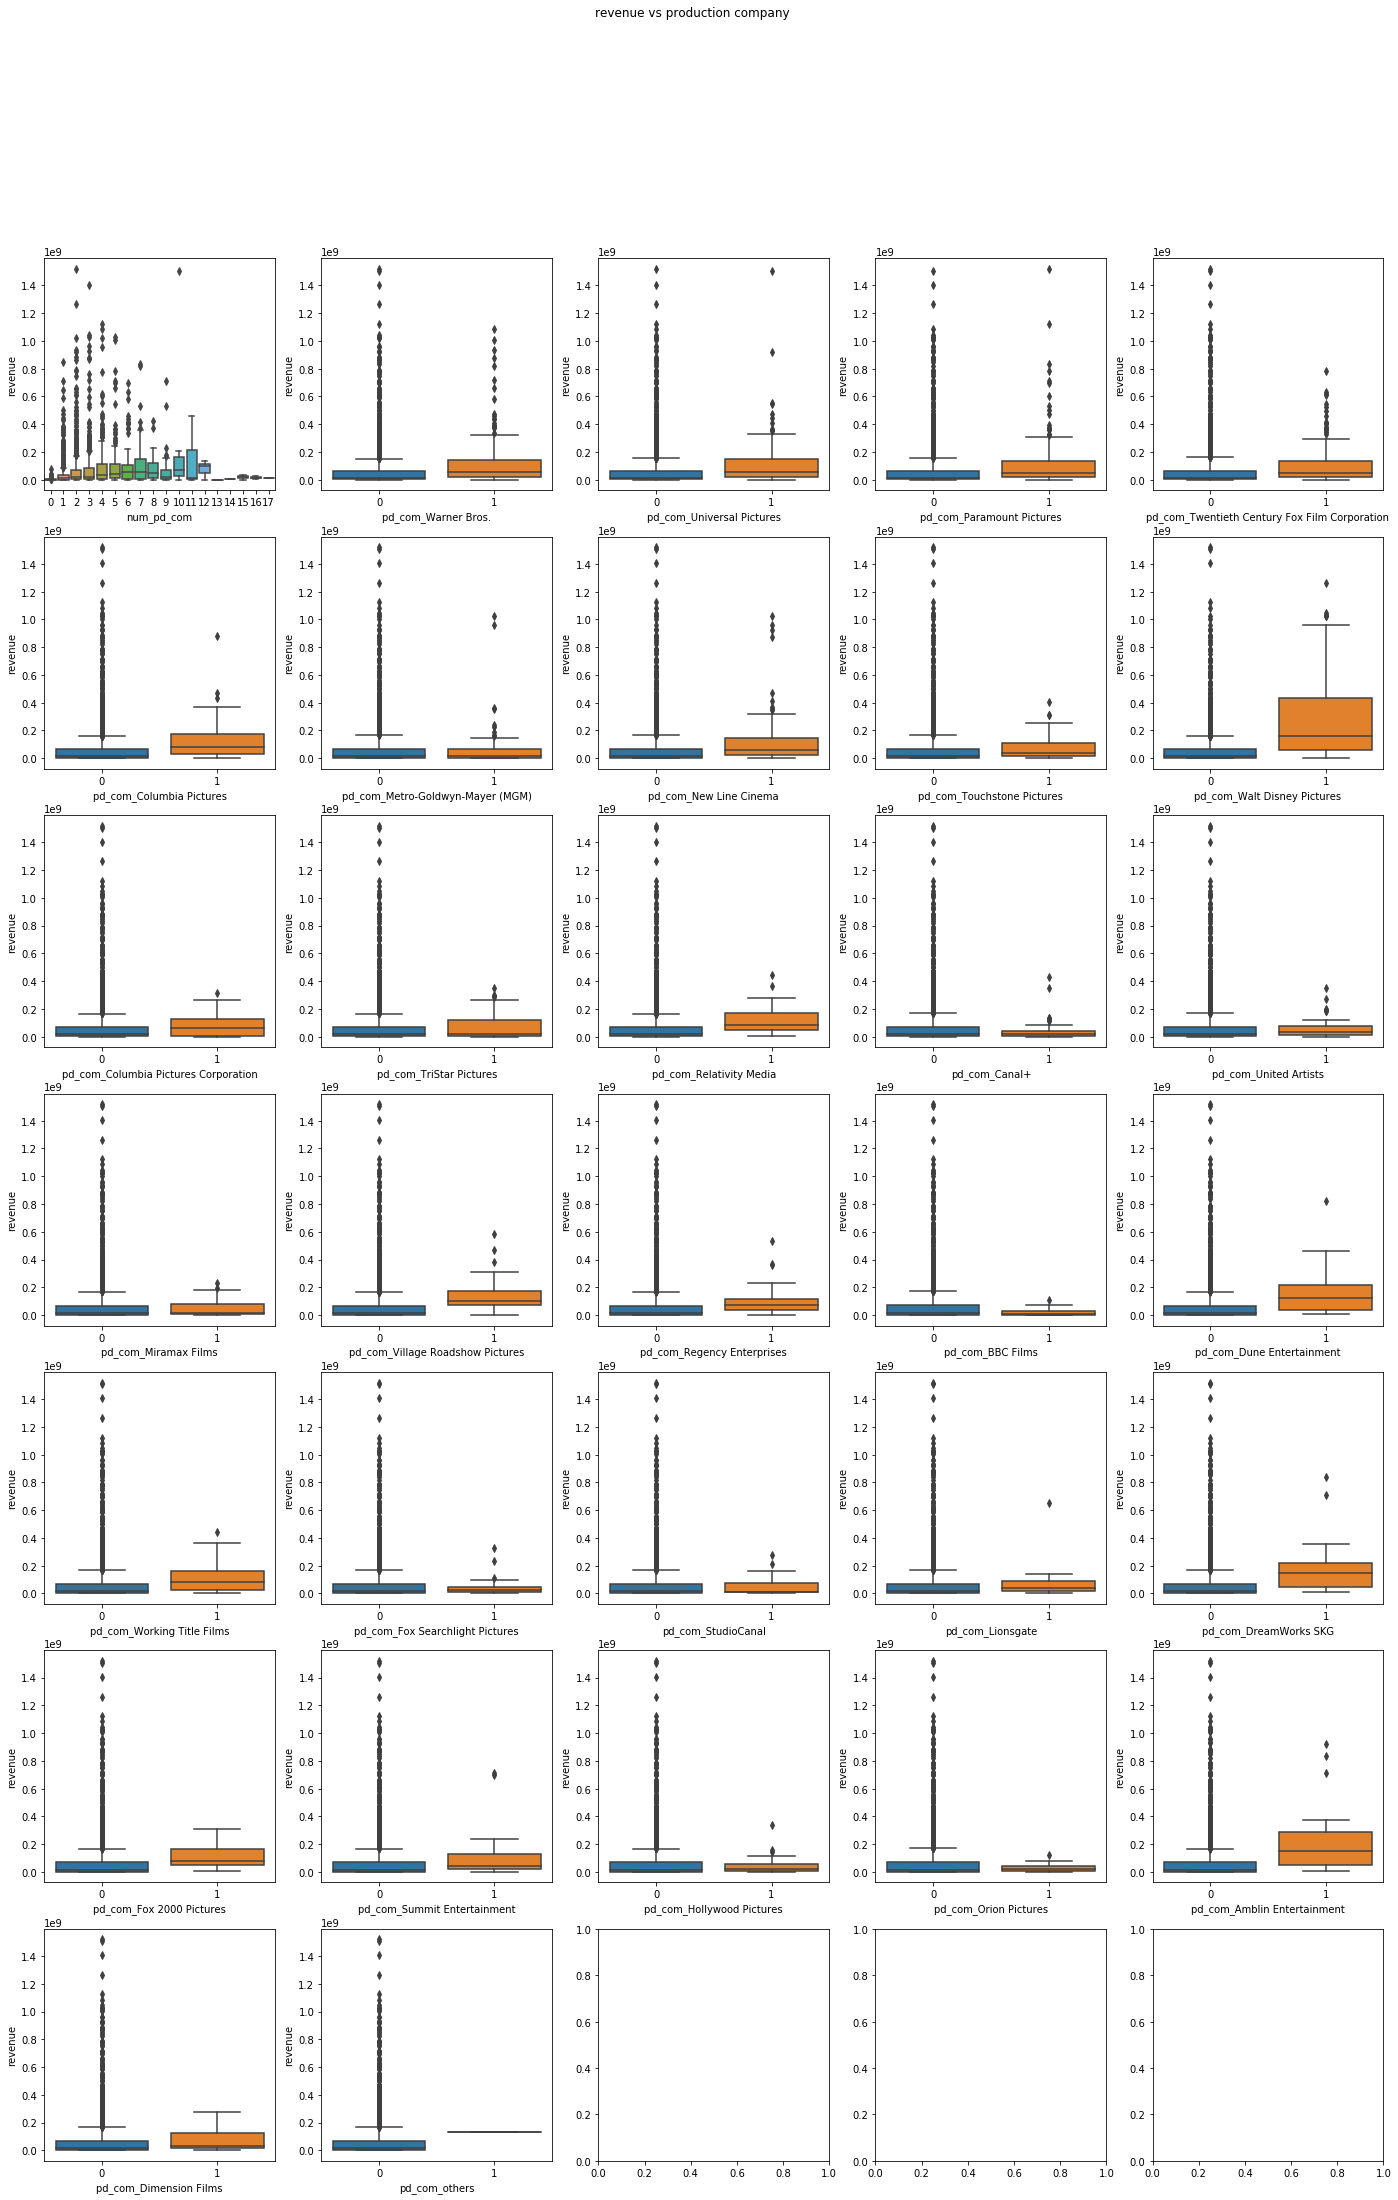

In [229]:
f, axes = plt.subplots(7, 5, figsize=(24, 35))
plt.suptitle('revenue vs production company')
for i, e in enumerate([col for col in train.columns if 'pd_com' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

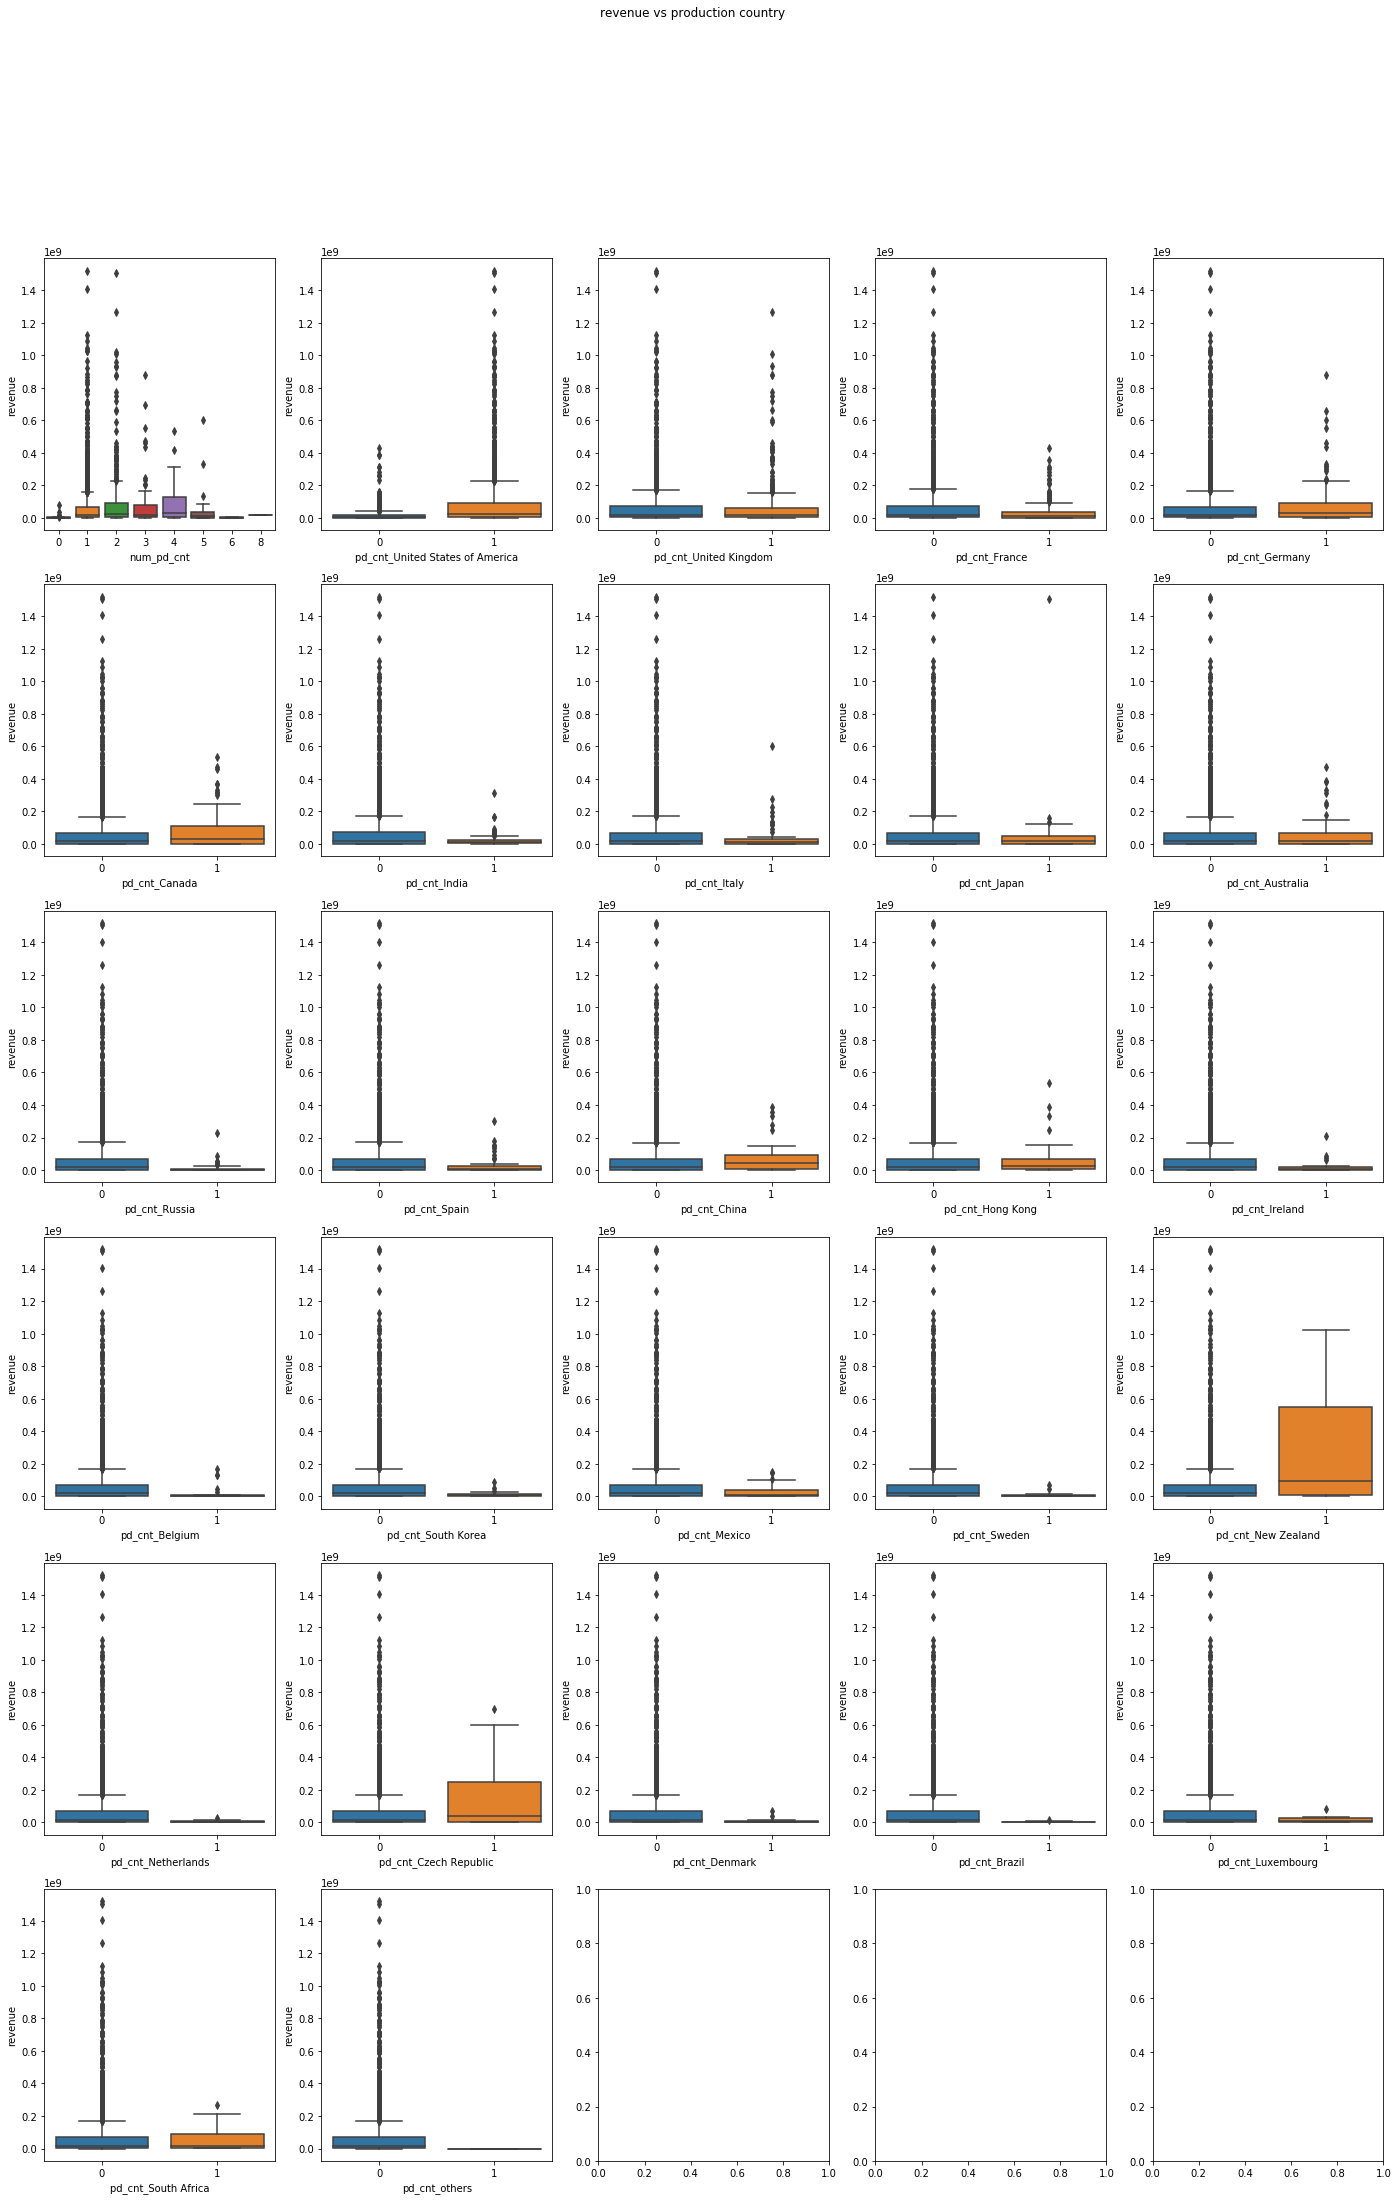

In [231]:
#production countries
f, axes = plt.subplots(6, 5, figsize=(24, 35))
plt.suptitle('revenue vs production country')
for i, e in enumerate([col for col in train.columns if 'pd_cnt' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

Text(0.5, 1.0, 'Number of cast members vs revenue')

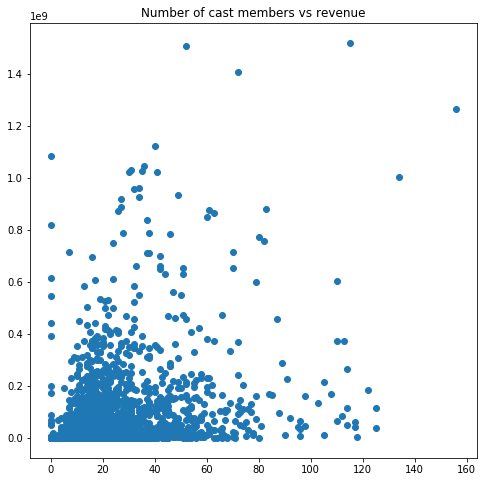

In [241]:
#cast
plt.figure(figsize=(8, 8))
plt.scatter(train['num_cast'], train['revenue'])
plt.title('Number of cast members vs revenue')

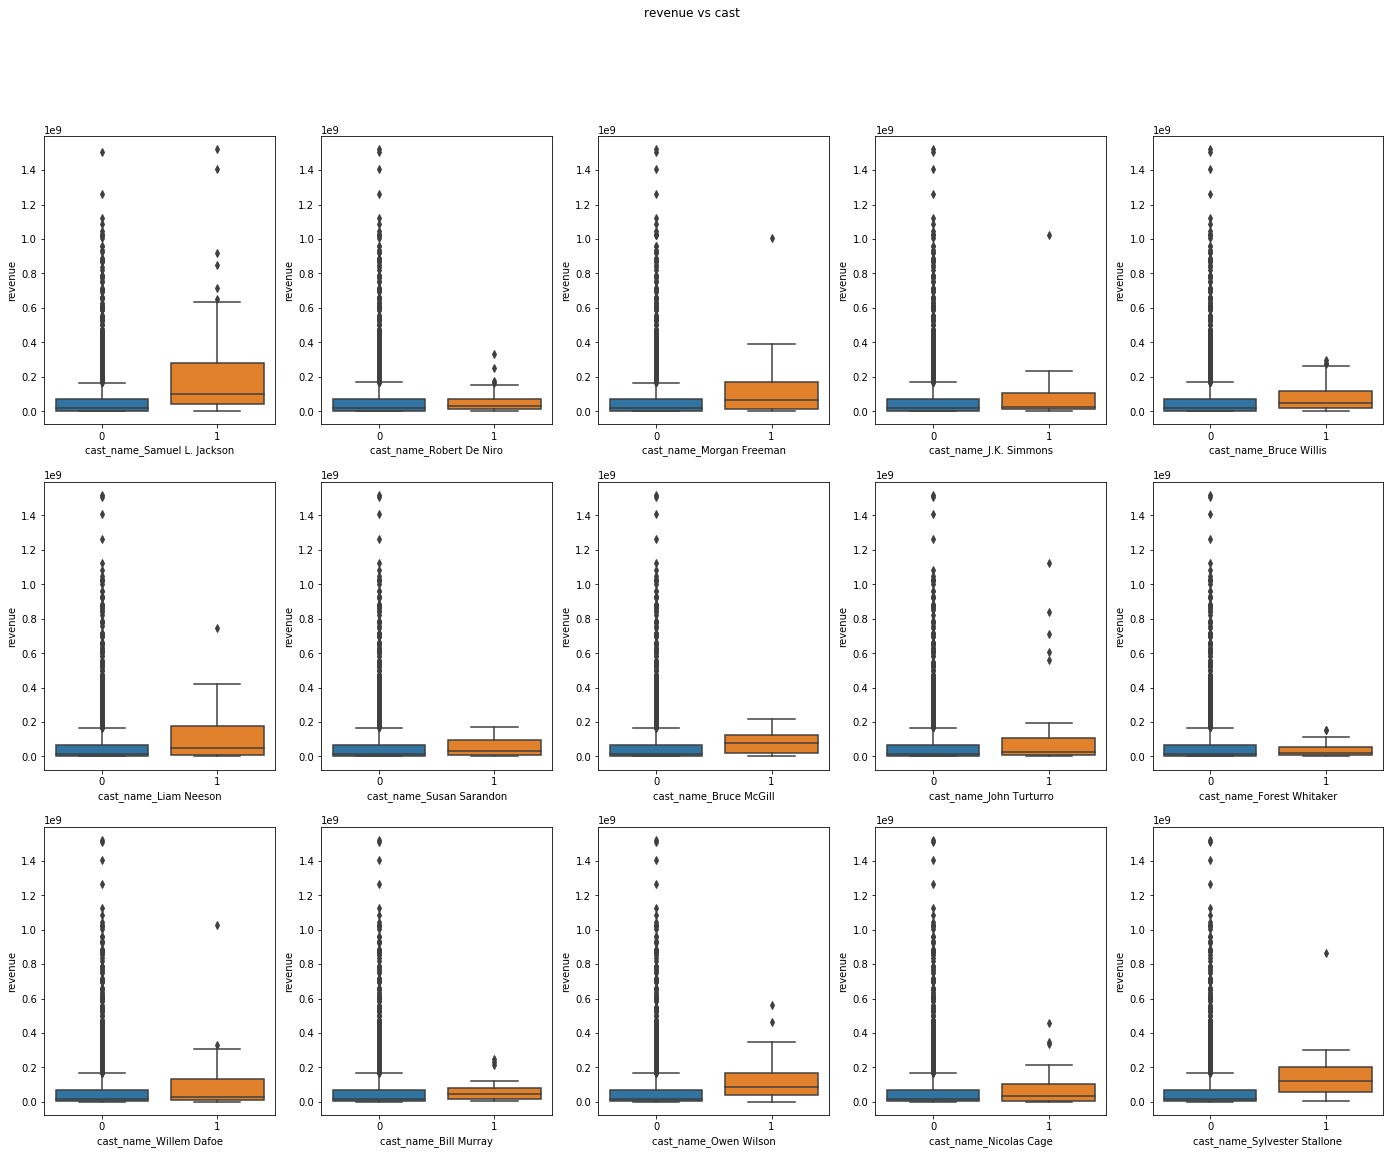

In [235]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_name' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

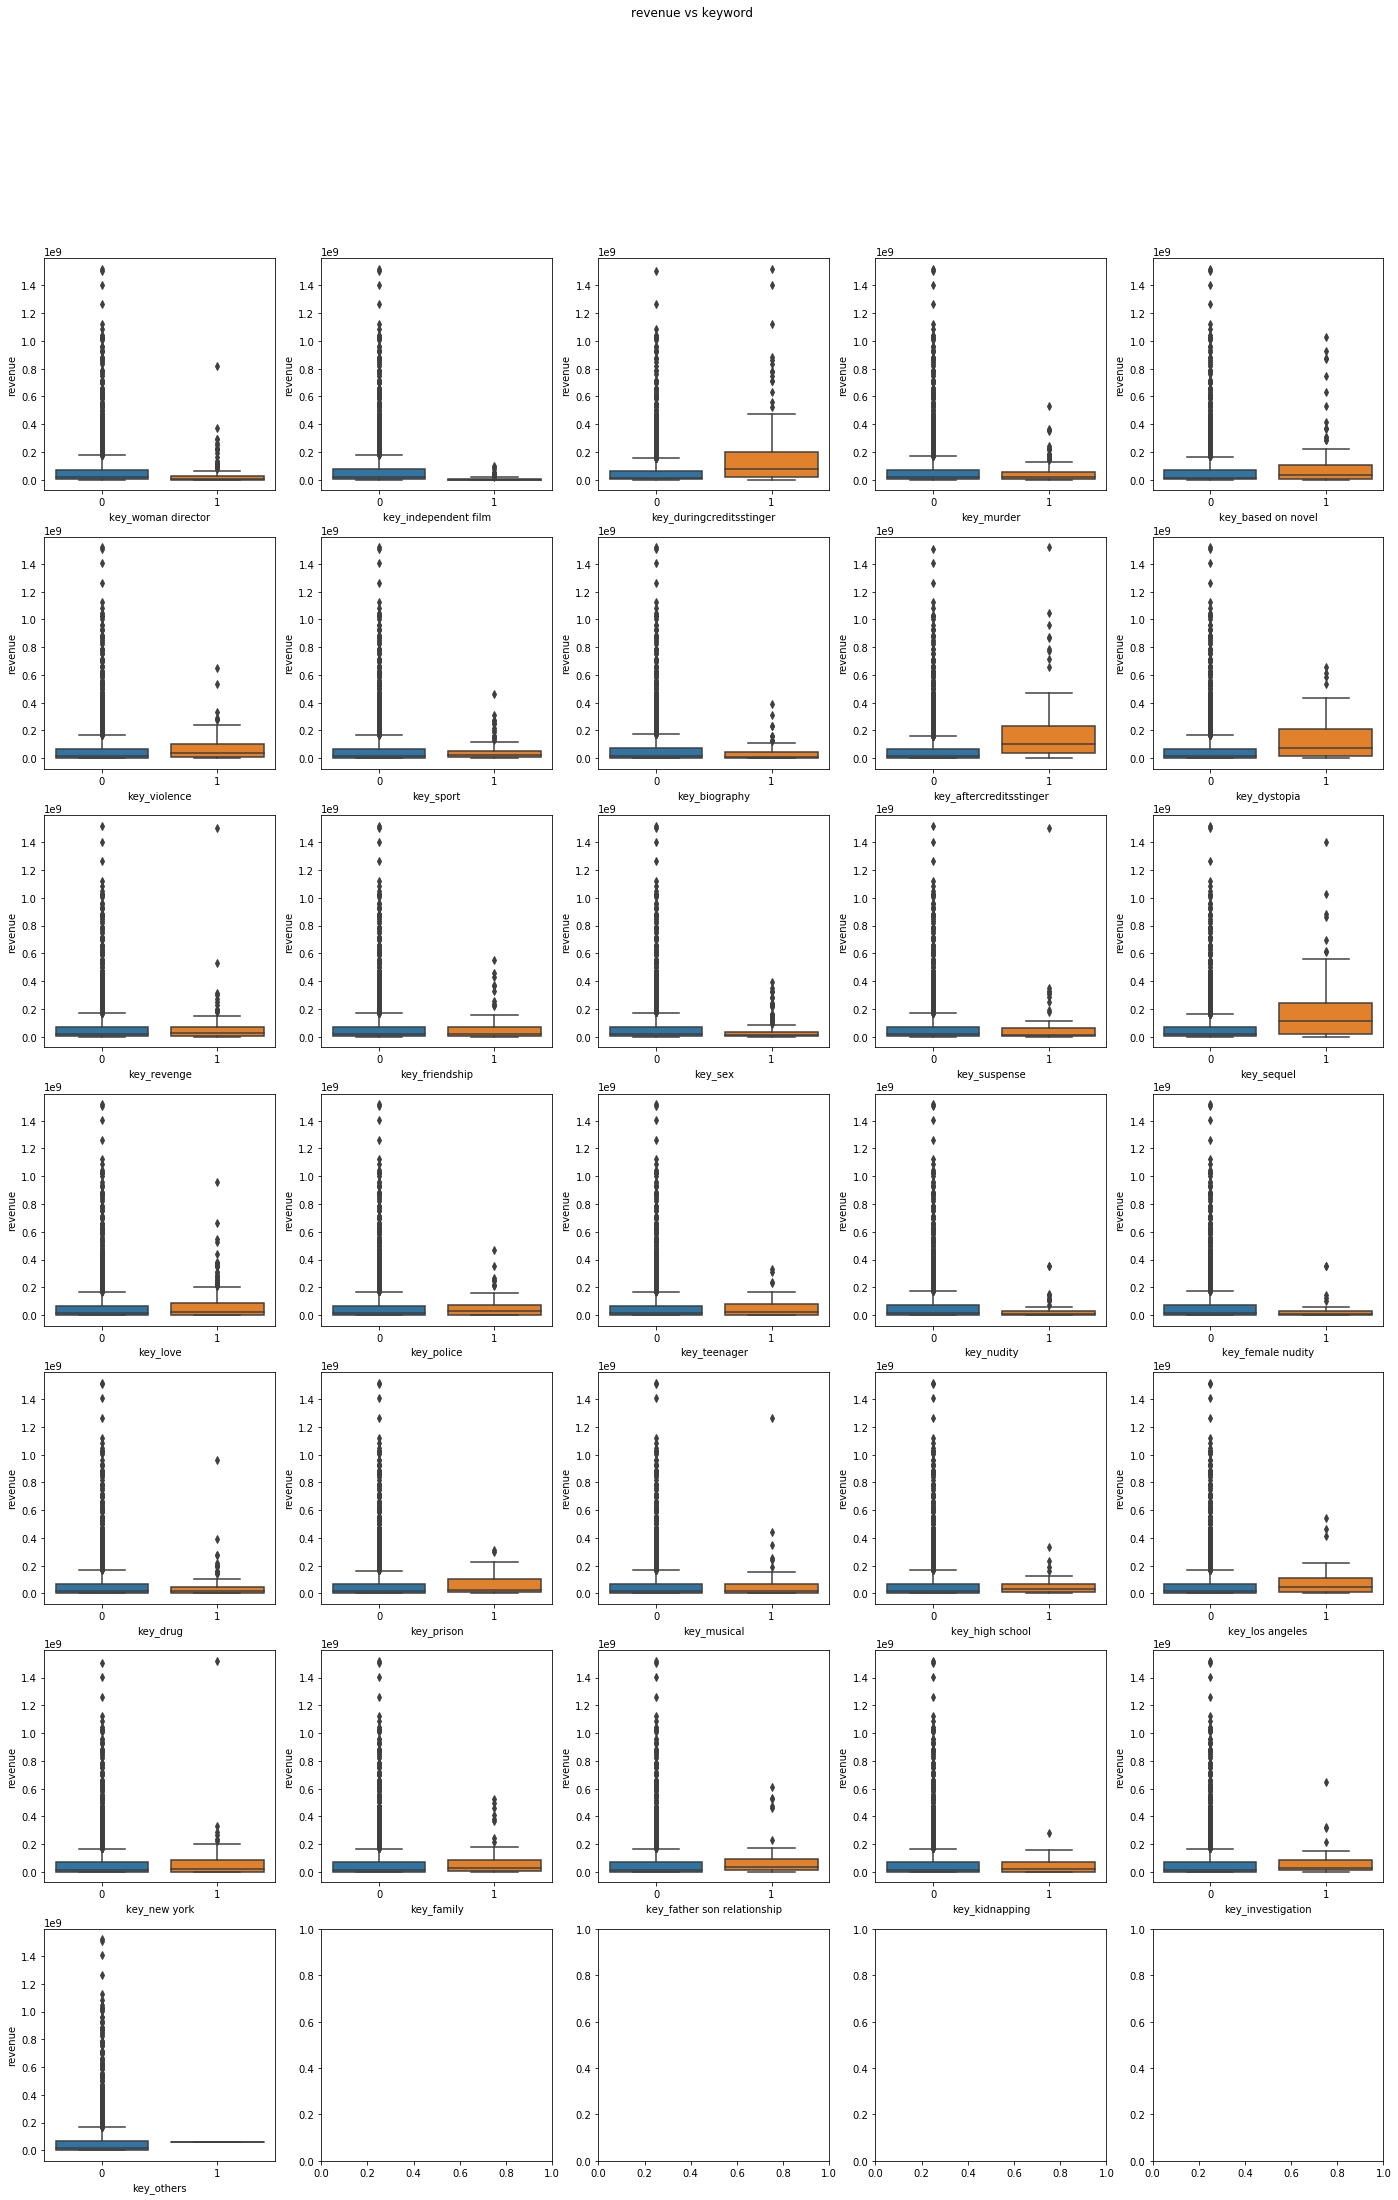

In [238]:
#Keywords
f, axes = plt.subplots(7, 5, figsize=(24, 35))
plt.suptitle('revenue vs keyword')
for i, e in enumerate([col for col in train.columns if 'key_' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

Text(0.5, 1.0, 'Number of crew members vs revenue')

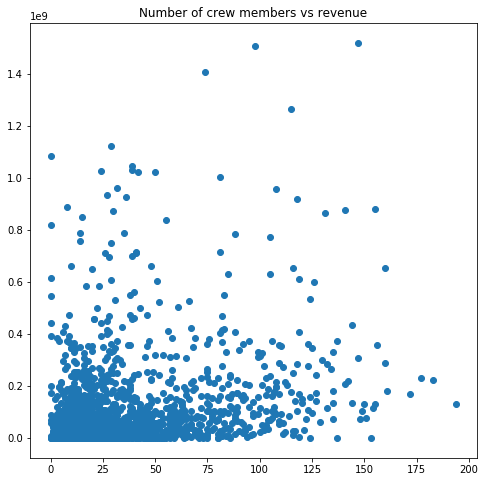

In [240]:
#crew
plt.figure(figsize=(8, 8))
plt.scatter(train['num_crew'], train['revenue'])
plt.title('Number of crew members vs revenue')


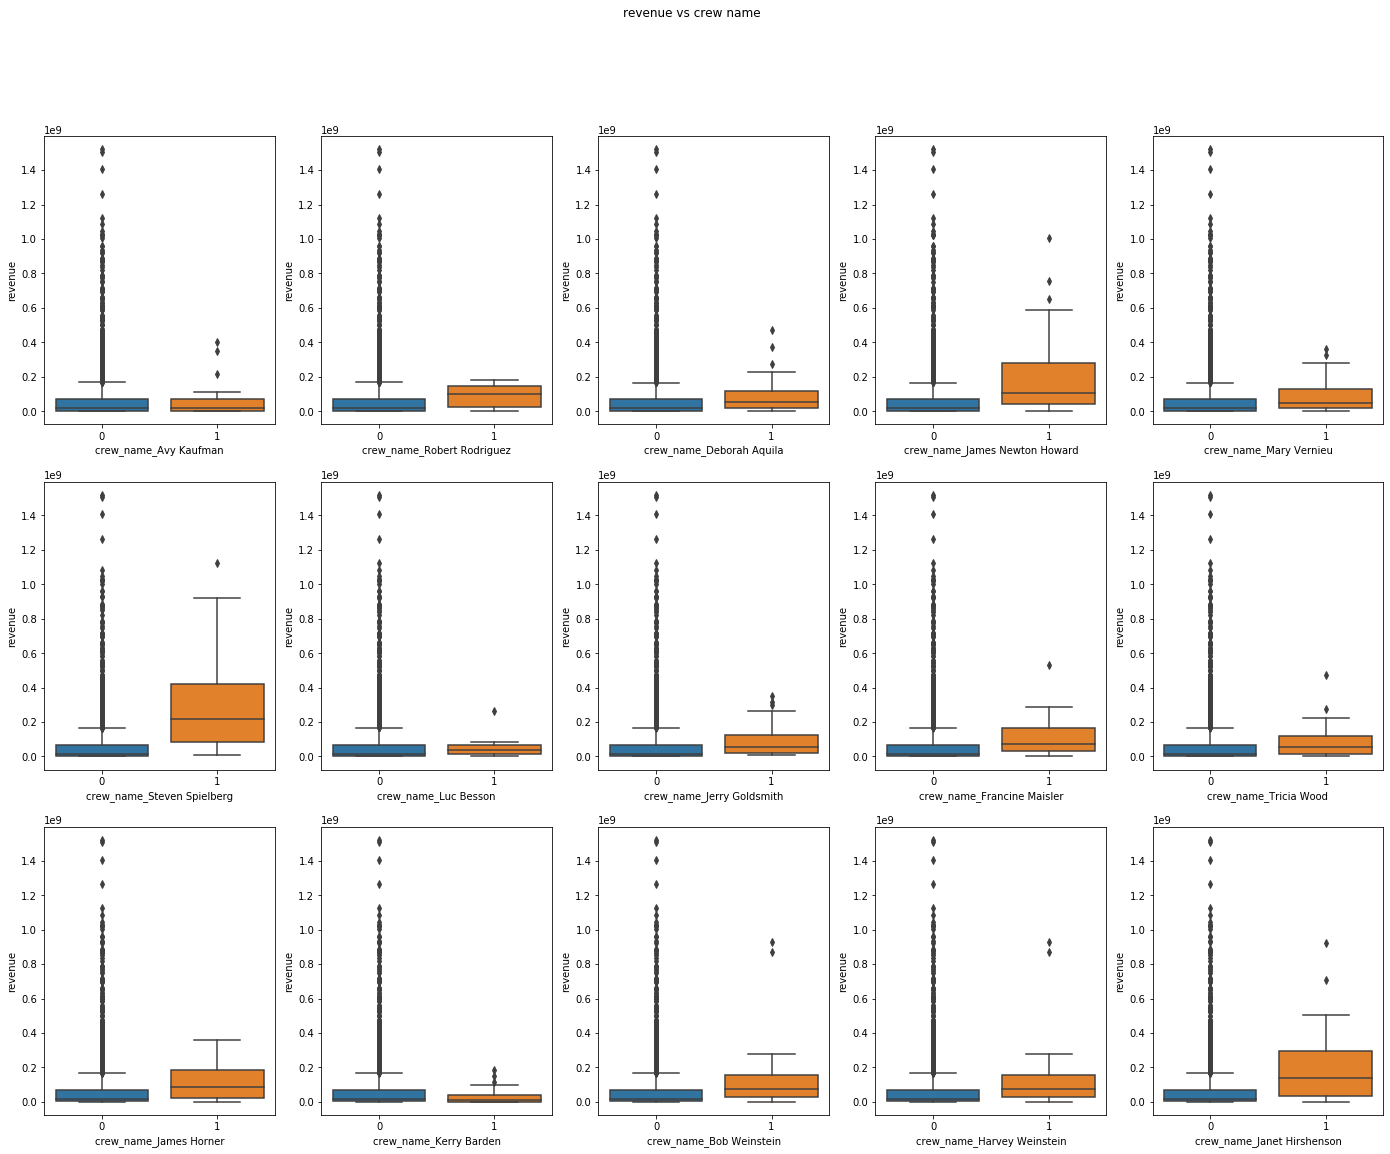

In [244]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('revenue vs crew name')
for i, e in enumerate([col for col in train.columns if 'crew_name_' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

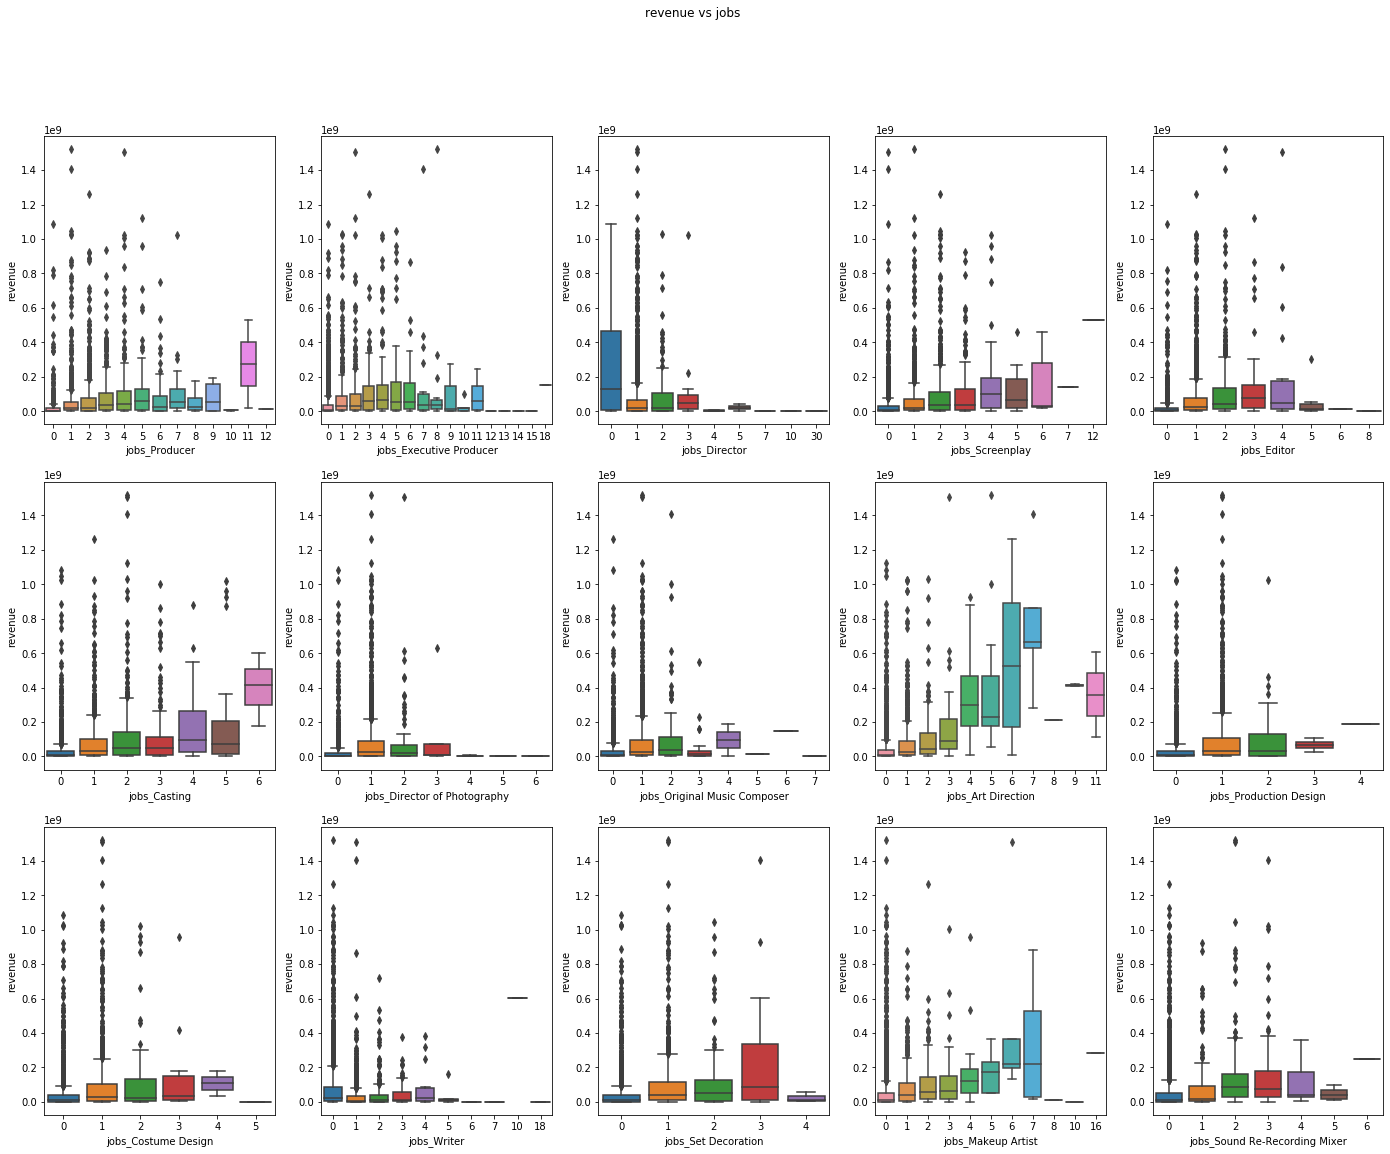

In [245]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('revenue vs jobs')
for i, e in enumerate([col for col in train.columns if 'jobs_' in col]):
    sns.boxplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

In [247]:
#drop columns
train = train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)
test = test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)